# PROBLEM DESCRIPTION
You’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

[Google analytics customer revenue prediction](https://www.kaggle.com/c/ga-customer-revenue-prediction)

Each row in the _train_v2.csv_ and _test_v2.csv_ dataset is one visit to the store. 

_train_v2.csv_ - contains user transactions from August 1st 2016 to April 30th 2018.

_test_v2.csv_  - contains user transactions from May 1st 2018 to October 15th 2018.

Because we are predicting **the log of the total revenue per user**, be aware that not all rows in _test_v2.csv_ will correspond to a row in the submission, but all unique **fullVisitorIds** will correspond to a row in the submission.

We're trying to predict **the log of the total revenue per user** for the period of December 1st 2018 to January 31st 2019.

In [ ]:
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt, seaborn as sns
import json, re, gc                              #garbage collector
from sklearn.preprocessing import LabelEncoder
from ast import literal_eval
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV #Experimented hyperparams a bit with this

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass
gc.enable()
sns.set(style='whitegrid',palette='deep',font_scale=1.1,rc={'figure.figsize':[8,6]})
pd.set_option('float_format', '{:f}'.format)     #to display full numbers in dataframe and not just exponentiated form 

# INTRODUCTION TO THE DATA

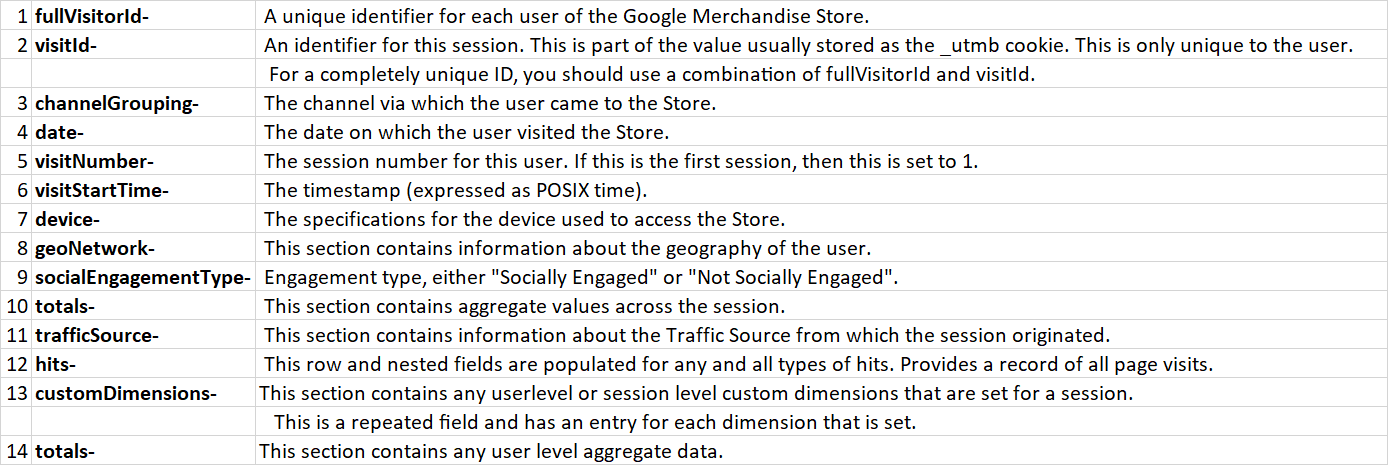


### NOTE-
* For __pd.read_csv()__, use a parameter _'chunksize'_ since we have a very large file size, a _'parse_dates'_ parameter to recognize _'date'_ values, and a _'converters'_ parameter to transform values in certain columns, using a dict of functions.

* In the below code-cell, I convert values in each value of the _JSON_COLUMN_ columns into a json-interepreted format.

* Data-extraction-strategy inspired from [Burrito Dan (excellent name)](https://www.kaggle.com/burritodan/gstore-pythonic-flatten-only-hits-column?select=hits-00000.csv) and [Prachi Panchal](https://www.kaggle.com/ppanchak/gstore-predictions).

> A 'hit': It is a user-interaction that results in data being sent to Google-Analytics.

> Each time the tracking code is triggered by a user’s behavior (for example, user loads a page on a website or a screen in a mobile app), Google-Analytics records that activity. Each interaction is packaged into a hit and sent to Google’s servers.“


The 'hits' column was specifically pretty complex in structure. Hence I'll attempt to parse & load it seperately later and merge it into the main train/test dataframe. Here's a single entry to show you the content:

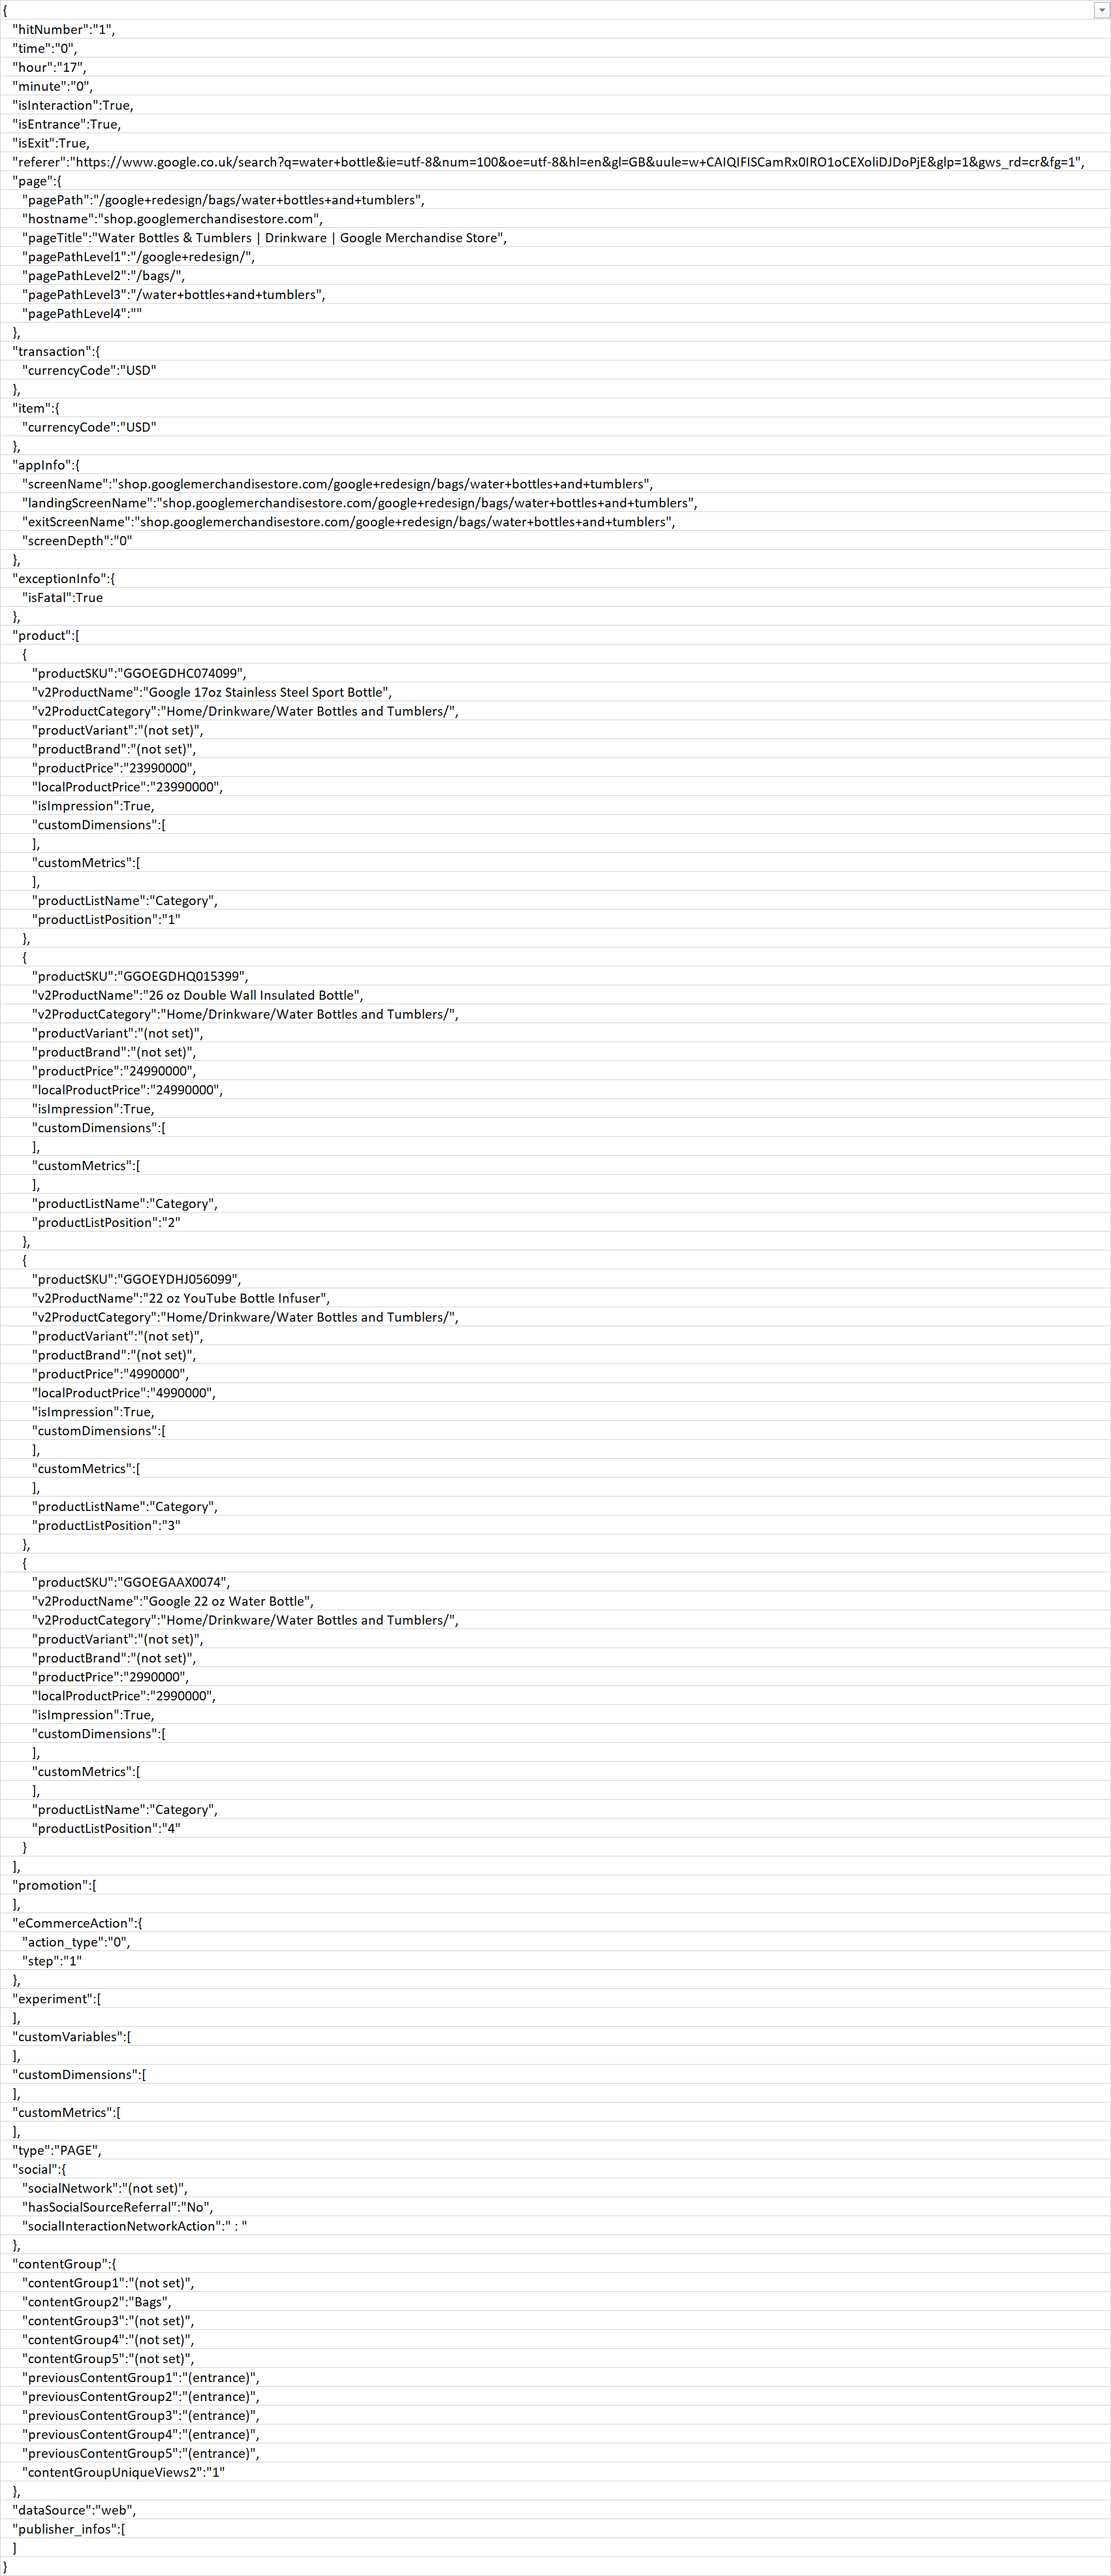

In [ ]:
''' THIS WAS AN INITIAL APPROACH TO STANDARDIZE DATA, SKIP OVER THIS CELL '''

def drop_messy_cols(df):
    #print(df.dtypes)
    numeric_cols=list(df.select_dtypes(include=['int32','int64','float32']).columns)
    categorical_cols=list(df.select_dtypes(include=['object']).columns)
    bool_cols=list(df.select_dtypes(include=['bool']).columns)


    ''' TO FIND WHICH CATEGORICAL COLUMNS HAVE LOW CARDINALITY '''
    low_cardinality_cols=[col for col in categorical_cols if df[col].nunique()<10]
    print('\n########################## LOW CARDINALITY COLUMNS: ##########################\n',df[low_cardinality_cols].nunique())


    ''' TO FIND WHICH CATEGORICAL COLUMNS HAVE V HIGH CARDINALITY '''
    high_cardinality_cols=[col for col in categorical_cols if df[col].nunique()>10 and col not in [
                                        'totals.transactionRevenue','fullVisitorId', 'totals.hits', 'device.operatingSystem', 'geoNetwork.metro'
                                        'totals.pageviews','trafficSource.source']
                          ]
    print('\n########################## HIGH CARDINALITY COLUMNS: ##########################\n',df[high_cardinality_cols].nunique())



    ''' TO FIND WHICH COLUMNS HAVE <na> IN LARGE NUMBERS '''
    high_na_cols=[col for col in df.columns if df[col].isna().sum()>10000 and col not in ['totals.transactionRevenue']]
    print('\n########################## COLUMNS WITH \'na\' IN LARGE NUMBERS: ##########################\n',df[high_na_cols].isna().sum())



    _COLS_TO_DROP = ['visitNumber', 'totals.newVisits', 'totals.bounces', 'trafficSource.isTrueDirect', 'geoNetwork.city', 'geoNetwork.networkDomain',
                     'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adContent', 'trafficSource.campaign', 'trafficSource.keyword', 
                     'trafficSource.referralPath', 'device.isMobile'
                    ]

    df.drop(columns=_COLS_TO_DROP , inplace=True, axis=1)
    return df



def preprocess_and_impute(train_df, test_df):
    full_df=pd.concat([train_df,test_df],axis=0)
    
    ''' DROP COLS WITH (V HIGH CARDINALITY & NOT MUCH RELEVANCE) , (COLS WITH CONSTANT VAL) , (V HIGH NUMBER OF <na> VALS) '''
    full_df=drop_messy_cols(full_df)
    
    ''' IDENTIFY COUNTRY_NAMES WITH LESS THAN 10 TRANSACTIONS AND SET THEM TO <Other> TO AVOID HIGH CARDINALITY '''
    _CNTRYS_LT_4_TRANSACTIONS = list(full_df.groupby('geoNetwork.country')['totals.transactions'].sum()[full_df.groupby('geoNetwork.country')['totals.transactions'].sum()<4].index)
    full_df['geoNetwork.country'][full_df['geoNetwork.country'].isin(_CNTRYS_LT_4_TRANSACTIONS)]='Other'
    
    
    ''' I IDENTIFIED BROWSER NAMES WHICH SEEM LEGIT, AND SET THE REST TO <Others> TO AVOID HIGH CARDINALITY '''
    _VALID_BROWSERS = [ 'Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Android Webview', 'Edge', 'Samsung Internet']
    full_df['device.browser'][~full_df['device.browser'].isin(_VALID_BROWSERS)]='Other'
    
    
    ''' I IDENTIFIED OS NAMES WHICH SEEM LEGIT, AND SET THE REST TO <Other> TO AVOID HIGH CARDINALITY '''
    _VALID_OPERATING_SYSTEMS = ['Windows', 'Macintosh', 'Android', 'iOS', 'Linux', 'Chrome OS', 'Windows Phone', 'Samsung']
    full_df['device.operatingSystem'][~full_df['device.operatingSystem'].isin(_VALID_OPERATING_SYSTEMS)]='Other'
    
    
    ''' IDENTIFY METRO_NAMES LEADING TO 0 TRANSACTIONS AND SET THEM TO <Other> TO AVOID HIGH CARDINALITY '''
    _SPARSE_METROS= list(full_df.groupby('geoNetwork.metro')['totals.transactions'].sum()[full_df.groupby('geoNetwork.metro')['totals.transactions'].sum()<1].index)
    print('\nFound {} sparse-metros. The entire dataset still has {} metros.'.format(len(set(_SPARSE_METROS)), len(set(full_df['geoNetwork.metro']))-len(set(_SPARSE_METROS))))
    full_df['geoNetwork.metro'][full_df['geoNetwork.metro'].isin(_SPARSE_METROS)]='Other'
    
    
    
    ''' IDENTIFY TRAFFIC SOURCES LEADING TO 0 TRANSACTIONS, AND SET THEM TO <Other> TO AVOID HIGH CARDINALITY '''
    _INEFFECTIVE_TRAFFIC_SOURCES=list(full_df.groupby('trafficSource.source')['totals.transactions'].sum()[full_df.groupby('trafficSource.source')['totals.transactions'].sum()<1].index)
    print('\nFound {} ineffective traffic-sources. The entire dataset still has {} traffic-sources.'.format(len(set(_INEFFECTIVE_TRAFFIC_SOURCES)), len(set(full_df['trafficSource.source']))-len(set(_INEFFECTIVE_TRAFFIC_SOURCES))))
    full_df['trafficSource.source'][full_df['trafficSource.source'].isin(_INEFFECTIVE_TRAFFIC_SOURCES)]='Other'
    
    full_df['trafficSource.source'][full_df['trafficSource.source'].str.contains('google')]='google'
    full_df['trafficSource.source'][full_df['trafficSource.source'].str.contains('facebook')]='facebook'
    full_df['trafficSource.source'][full_df['trafficSource.source'].str.contains('yahoo')]='yahoo'
    print('\n\nLIST OF trafficSource.source: ',list(full_df['trafficSource.source'].value_counts().index))
    
    
    full_df['date.year']=full_df['date'].dt.year
    full_df['date.month']=full_df['date'].dt.month
    full_df['date.weekday']=full_df['date'].dt.weekday
    full_df['date.day']=full_df['date'].dt.day

    del(full_df['date'])
    ''' ENCODE THE FINAL CATEGORICAL COLS INTO LABEL-ENCODINGS OF <n-1> VALUES EACH '''
    _CAT_COLS_FOR_ENCODER = ['channelGrouping', 'date.year','date.month', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 
                             'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'trafficSource.medium', 'trafficSource.source']
    for col in _CAT_COLS_FOR_ENCODER:
        lb = LabelEncoder()
        full_df[col]=lb.fit_transform(full_df[col])
    return full_df

This initial approach of encoding categorical data was leading to these observations:
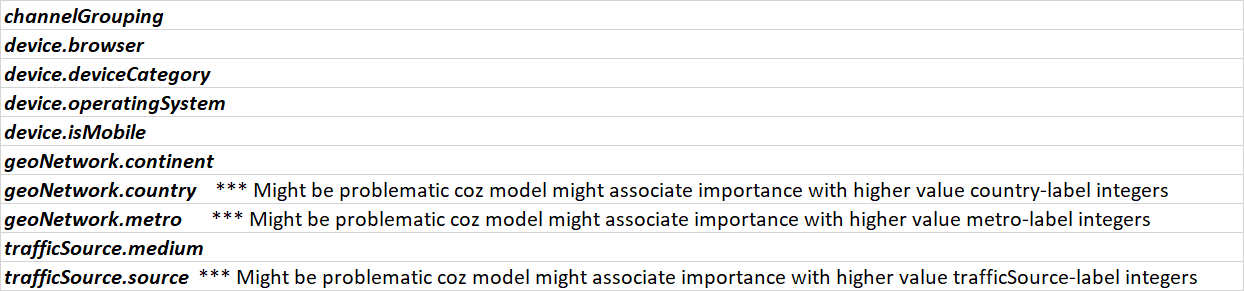

# ETL FUNCTIONS AND DATA-WRANGLING


Utility variables to note in below code-cell:
*  **_JSON_COLUMNS** : [ ] variable of 4 columns that after EDA, have JSON nested data values

*  **_FEATURES_WITHOUT_HITS** : [ ] variable of 29 columns which by my intuition, should be relevant to feeding into the regression model ahead

*  **_COL_VALUES_TO_BE_REPLACED** : { } variable with 11 key-value pairs of column-names and data-values to be replaced by 'NA
*  **_COLS_TO_CONVERT_TO_INT** : [ ] variable of 6 columns to be converted into integer dtype.

In [ ]:
def load_df_without_hits(path=dirname+'/train_v2.csv'):
    ans=pd.DataFrame()
    dfs=pd.read_csv(path, parse_dates=['date'],
                    converters={ j: json.loads for j in _JSON_COLUMNS },
                    dtype={'fullVisitorId':str}, chunksize=100000
                   )
    
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        #print(df.hits[0])
        
        ''' PROCESS COLS WITH JSON DATA '''        
        for col in _JSON_COLUMNS:
            column_as_df= pd.json_normalize(df[col])
            #print(column_as_df.columns)
            column_as_df.columns=[f'{col}.{subcolumn}' for subcolumn in column_as_df.columns]
            df=df.drop(col, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
        ''' REPLACE STRANGE <unknown> VALUES INTO <na> '''
        df=df.replace( _COL_VALUES_TO_BE_REPLACED , 'NA')
        
        
        
        ''' CONVERT <object> dtype COLS INTO <integer> VALUE COLS WHEREVER NEEDED '''
        for col in _COLS_TO_CONVERT_TO_INT:
            df[col] = df[col].fillna(1).astype(int)
        
        
        ''' IMPUTE totals.transactionRevenue WITH 0 VALUE '''
        df['totals.transactionRevenue'] = df['totals.transactionRevenue'].fillna(0).astype(float)
        df['totals.totalTransactionRevenue'] = df['totals.totalTransactionRevenue'].fillna(0).astype(float)
        
        
        ''' CHOOSE ONLY A FEW OF THE COLS INCLUDING NESTED JSON COLS '''
        use_df = df[_FEATURES_WITHOUT_HITS]
        del df
        gc.collect()
        
        ans = pd.concat([ans, use_df], axis = 0).reset_index(drop = True)
        if ans.shape[0]%200000==0:
            print(f"Loaded {os.path.basename(path)} and now df= {ans.shape}")    
    return ans






''' IDENTIFIED COLUMN NAMES WITH NESTED JSON DATA '''
_JSON_COLUMNS = [
    'device','geoNetwork','totals','trafficSource'
    ]



''' TO KEEP ONLY A FEW OF THE COLS INCLUDING NESTED JSON COLS '''
_FEATURES_WITHOUT_HITS = [
    'channelGrouping', 'date', 'fullVisitorId', 'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime', 
    'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
    'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent',        
    'totals.hits', 'totals.pageviews', 'totals.transactionRevenue','totals.totalTransactionRevenue', 'totals.sessionQualityDim', 'totals.transactions', 'totals.bounces', 'totals.newVisits', 'totals.timeOnSite',
    'trafficSource.medium', 'trafficSource.source', 'trafficSource.isTrueDirect', 'trafficSource.keyword','trafficSource.campaign','trafficSource.referralPath', 'trafficSource.adContent', 
    'trafficSource.adwordsClickInfo.slot'
    ]



''' TO CONVERT <object> dtype COLS INTO <integer> VALUE COLS WHEREVER NEEDED '''
_COLS_TO_CONVERT_TO_INT =  [
    'totals.pageviews', 'totals.hits', 'totals.sessionQualityDim',
    'totals.visits', 'totals.timeOnSite', 'totals.transactions'
    ]




''' TO REPLACE STRANGE <unknown> VALUES TO <na> '''
_COL_VALUES_TO_BE_REPLACED = {
            'device.operatingSystem' :      ['not available in demo dataset','(not set)'],
            'device.browser' :              ['not available in demo dataset','(not set)','0'],
            'geoNetwork.city' :             ['not available in demo dataset','(not set)'],
            'geoNetwork.metro' :            ['not available in demo dataset', '(not set)'], 
            'geoNetwork.networkDomain' :    ['unknown.unknown', '(not set)', 'not.configured'],
            'geoNetwork.region' :           ['not available in demo dataset','(not set)'],
            'geoNetwork.continent' :        ['not available in demo dataset','(not set)'],
            'geoNetwork.subContinent' :     ['not available in demo dataset','(not set)'],
            'geoNetwork.country' :          ['not available in demo dataset','(not set)'],
            'trafficSource.campaign' :      ['not available in demo dataset','(not set)'],
            'trafficSource.medium' :        ['(none)','(not set)'],
            'trafficSource.source' :        '(not set)'
            }

# LOADING 'train_v2.csv' WITHOUT 'hits' COLUMN
Invoking the above functions to read chunks of the huge file: _train_v2.csv_

In [ ]:
%%time
print('{} Reading the 27 Gig \'train_v2.csv\' will take ~18 minutes time! Grab a coffee in the meanwhile. {}\n'.format('#'*26 , '#'*26))
train = load_df_without_hits(path=dirname+'/train_v2.csv')
print(list(train.columns))
train_bkp=train.copy()

# LOADING 'test_v2.csv' WITHOUT 'hits' COLUMN
Invoking the above functions to read chunks of the huge file: _test_v2.csv_

In [ ]:
%%time
print('{} Reading the 7 Gig \'test_v2.csv\' will take ~4 minutes time! Go hydrate in the meanwhile :) {}\n'.format('#'*26 , '#'*26))
test = load_df_without_hits(path=dirname+'/test_v2.csv')
print(list(test.columns))

In [ ]:
train_shape = train.shape
test_shape = test.shape
print('Train_Shape=',train_shape)
print('Test_Shape=',test_shape)

# PROCESSING THE 'hits' COLUMN IN 'train_v2.csv'
We'll need to create this as a function so as to have a final consolidated 'train' dataframe after concatenation.

reader=pd.read_csv(dirname+'/train_v2.csv', usecols=[4,10,6], chunksize=100000)
hit_features=['fullVisitorId','visitId','hits']
for chunk in reader:
    
    chunk=chunk[hit_features]
    print(chunk.columns,'Shape of chunk=', chunk.shape)
    chunk['hits'][chunk['hits']=='[]'] = '[{}]'      # SET THE 'hits' COL VALUE = '[{}]' , WHERE IT IS JUST '[]'
    
    print('This next line takes a hell of a lot of time!')
    chunk['hits'] = chunk['hits'].apply(literal_eval).str[0]
    #print(chunk.hits[0])                            # UNCOMMENT THIS TO VIEW THE RAW JSON INSIDE 'hits' COLUMN, FIRST ROW
    
    chunk=pd.json_normalize(chunk['hits'])
    if 'product' in chunk.columns:
        chunk['v2ProductName']   =   chunk['product'].apply(lambda x: [p['v2ProductName'] for p in x] if type(x)==list else [])
        chunk['v2ProductCategory'] = chunk['product'].apply(lambda x: [p['v2ProductCategory'] for p in x] if type(x)==list else [])
        del(chunk['product'])     #del is an inplace operation instead of chunk.drop('col',axis=1)
    if 'promotion' in chunk.columns:
        chunk['promoId']         =   chunk['promotion'].apply(lambda x: [p['promoId'] for p in x] if type(x)==list else [])
        chunk['promoName']         = chunk['promotion'].apply(lambda x: [p['promoName'] for p in x] if type(x)==list else [])
        del(chunk['promotion'])   #del is an inplace operation instead of chunk.drop('col',axis=1)
    gc.collect()
    chunk.to_csv('../input/output/Chunk_Hits001.csv',index=False)   # WRITING TO CSV SO THAT I CAN MANUALLY READ THE CSV FILE
    break

# MEAT OF THE ENTIRE NOTEBOOK: EXPLORATORY DATA-ANALYSIS
Below I'll attempt to find some aggregation logics so that we have a unique entity per (fullVisitorId, visitId) combination. I'd much rather do this in SQL since I'm proficient there, but here goes.

'totals.transactionRevenue' is captured in a cumulative manner for each year. So for one visitor's yearly data, we can consider max() as his total contribution towards GStore's revenue.

At the end of each year, that user's transactionRevenue value seems to be reset.

In [ ]:
full_df=pd.concat([train,test],axis=0)
_VALID_BROWSERS = [ 'Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Android Webview', 'Edge', 'Samsung Internet']
full_df['device.browser'].loc[~full_df['device.browser'].isin(_VALID_BROWSERS)]='Other'

_VALID_OPERATING_SYSTEMS = ['Windows', 'Macintosh', 'Android', 'iOS', 'Linux', 'Chrome OS', 'Windows Phone', 'Samsung']
full_df['device.operatingSystem'].loc[~full_df['device.operatingSystem'].isin(_VALID_OPERATING_SYSTEMS)]='Other'

full_df['date.weekday']=full_df['date'].dt.weekday
full_df['date.day']=full_df['date'].dt.day
full_df['date.month']=full_df['date'].dt.month
full_df['date.year']=full_df['date'].dt.year

print(full_df.nunique()[full_df.nunique()==1].index)
del(full_df['totals.bounces'])
del(full_df['totals.newVisits'])
del(full_df['socialEngagementType'])
del(full_df['trafficSource.isTrueDirect'])

In [ ]:
full_df[['fullVisitorId','channelGrouping','date','visitNumber','totals.transactions','totals.transactionRevenue']][
    full_df['fullVisitorId']=='9974232250427988367'].sort_values(by=['date','visitNumber'])

In [ ]:
visitors_in_both_years= set(full_df['fullVisitorId'][full_df['date.year']==2016]).intersection(set(full_df['fullVisitorId'][full_df['date.year']==2017]))
tmp_df=full_df[['fullVisitorId', 'totals.transactionRevenue']][full_df['fullVisitorId'].isin(visitors_in_both_years)]
print(tmp_df.groupby('fullVisitorId')['totals.transactionRevenue'].count()[(tmp_df.groupby('fullVisitorId')['totals.transactionRevenue'].count()>1) 
                                                                      & (tmp_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum()!=0)])
del(tmp_df)
del(visitors_in_both_years)
del(full_df['visitId'])

In [ ]:
sns.distplot(full_df['totals.transactionRevenue'], norm_hist=True, kde=True,kde_kws={'bw': 0.1}, 
             bins=20, hist_kws={'alpha':1}).set(xlabel='Total Revenue',ylabel='Count of records in dataset')
plt.show()

In [ ]:
print(full_df.dtypes)
full_df.head(15)

In [ ]:
tmp_dist=pd.DataFrame(columns=['user_level_transactions'], data=full_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().values)

tmp_dist['user_level_transactions']=np.where(tmp_dist['user_level_transactions']==0, 
                                             'Users without a single transaction', 'Users with one or more transaction(s)')

plt.figure(figsize=(8,8))
plt.pie(x=tmp_dist['user_level_transactions'].value_counts(), colors=['orange','yellow'],
        labels=tmp_dist['user_level_transactions'].value_counts().index, autopct='%.2f%%')

plt.gcf().gca().add_artist(plt.Circle(xy=(0,0),radius=0.7,color='white'))
plt.title('Highly imbalanced dataset', fontdict={'fontweight':'bold'})
del(tmp_dist)
plt.show()
''' General data distribution '''

In [ ]:
''' Relationship between channelGrouping and transactionRevenue '''
fig, ax=plt.subplots(1,2, figsize=(12,10))

sns.countplot(x='channelGrouping',data=full_df, palette='twilight_shifted_r', ax=ax[0], order=full_df['channelGrouping'].value_counts(ascending=False).index).set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].set_title('# of visits vs \'channelGrouping\'', fontdict={'fontweight':'bold'})
sns.barplot(data=pd.pivot_table(data=full_df,index='channelGrouping',values='totals.transactionRevenue',aggfunc='mean').reset_index().sort_values(by='totals.transactionRevenue',ascending=False),
               x='channelGrouping', y='totals.transactionRevenue', palette='twilight_shifted_r', ax=ax[1]).set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].set_title('Mean Revenue vs \'channelGrouping\'', fontdict={'fontweight':'bold'})



plt.show()
''' <Referral> and <Direct> channels produce most revenue; <Organic Search> and <Social> lead to most visits but lead to very little revenue in the RHS plot '''

In [ ]:
plt.figure(figsize=(16,6))
yearly_channelwise_revenue = full_df.groupby(['date.year','channelGrouping'])['totals.transactionRevenue'].mean().reset_index()
sns.barplot(data=yearly_channelwise_revenue, x='date.year', y='totals.transactionRevenue', hue='channelGrouping', palette='twilight_shifted_r')
plt.show()
del(yearly_channelwise_revenue)
''' <Referral> gives most revenue each year, <Direct> is 2nd most for 2016,2018, and <Display> is most for 2017 '''

In [ ]:
plt.figure(figsize=(18,8))
monthwise_revenue = pd.pivot_table(data=full_df, index=['date.year', 'date.month'], 
                                   values='totals.transactionRevenue', aggfunc='mean').reset_index().sort_values(by='date.month')
monthwise_revenue['date.month'].replace({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'},inplace=True)

sns.barplot(data=monthwise_revenue, x='date.year', y='totals.transactionRevenue', hue='date.month', palette='icefire')
plt.show()
del(monthwise_revenue)
''' Most Revenue: August 2016, April 2017, and Sept 2018; August to November general trend of decreasing revenue '''

In [ ]:
plt.figure(figsize=(16,6))
full_df.groupby('date')['totals.transactionRevenue'].mean().plot()
plt.title('Revenue vs {}'.format('date'.capitalize()), fontdict={'fontweight':'bold'})
plt.show()
''' Revenue-Spikes around Sept 2016, Feb 2017, Apr 2017, Aug-Sept 2017, and Aug 2018 '''

In [ ]:
fig, ax= plt.subplots(1,2, figsize=(18,6))

weekday_revenue_dist = pd.pivot_table(data=full_df,index=['date.weekday'],values='totals.transactionRevenue',aggfunc='mean').reset_index()
sns.lineplot(data=weekday_revenue_dist,x='date.weekday',y='totals.transactionRevenue', palette='Accent', ax=ax[0])

weekly_revenue_dist=pd.pivot_table(data=full_df,index=['date.weekday','date.year'],values='totals.transactionRevenue',aggfunc='mean').reset_index()
sns.lineplot(data=weekly_revenue_dist,x='date.weekday',y='totals.transactionRevenue', hue='date.year', palette='Accent', ax=ax[1])
plt.show()
del(weekly_revenue_dist)
del(weekday_revenue_dist)
''' Overall sales dip on Saturday; On average: 2016 sales peak on Monday, 2017 sales peak on Wednesday, 2018 sales peak on Friday '''

In [ ]:
categorical_variables=['device.browser','device.isMobile','device.operatingSystem','device.deviceCategory']
color_schemes=['ocean_r', 'twilight_r', 'muted', 'autumn_r']
i=0
fig, ax = plt.subplots(2, 2, figsize=(16,12))
plt.subplots_adjust(wspace=.5, hspace=.7)
for variable, subplot in zip(categorical_variables, ax.flatten()):
    tmp = full_df.groupby(variable)['totals.transactionRevenue'].mean().reset_index().sort_values(ascending=False,by='totals.transactionRevenue')
    c=sns.barplot(data=tmp,x=variable,y='totals.transactionRevenue', ax=subplot, palette=color_schemes[i])
    c.set_xticklabels(subplot.get_xticklabels(),rotation=90)
    c.set_title('Revenue vs {}'.format(variable.replace('device.','').capitalize()), fontdict={'fontweight':'bold'})
    i+=1
plt.show()
''' <Browser> Firefox,Chrome,Edge ;  <isMobile> False ;  <OperatingSystem> ChromeOs,Mac,Linux,Windows ;  <DeviceType> Desktop give most revenue '''

In [ ]:
fig, ax= plt.subplots(1,2, figsize=(18,6))

op_ch_device_0 = pd.pivot_table(data=full_df,index=['device.deviceCategory','device.operatingSystem','channelGrouping'],
                              values='totals.transactionRevenue',aggfunc='mean').reset_index()
op_ch_device=op_ch_device_0[op_ch_device_0['totals.transactionRevenue']>0]
sns.barplot(data=op_ch_device, x='device.operatingSystem',y='totals.transactionRevenue', 
            hue='device.deviceCategory', palette='Accent', ax=ax[0], dodge=False).set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].set_title('Revenue vs OS-wise devices', fontdict={'fontweight':'bold'})
ax[0].set_ylim([0,2e7])
sns.barplot(data=op_ch_device, x='device.operatingSystem',y='totals.transactionRevenue', 
            hue='channelGrouping', palette='Accent_r', ax=ax[1], dodge=False).set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].set_title('Revenue vs OS-wise channel', fontdict={'fontweight':'bold'})
ax[1].set_ylim([0,2e7])
plt.show()
print(''' LHS: Chrome/Mac/Windows with Desktop gives most revenue ;  
 RHS: Referral visits leading to overall most revenue are spread across OS's ;
 RHS: Windows with Display channel gives most revenue ;''')
del(op_ch_device)
del(op_ch_device_0)

In [ ]:
plt.figure(figsize=(24,6))
citywise_revenue=pd.pivot_table(data=full_df, index=['geoNetwork.city'], values='totals.transactionRevenue', 
                                aggfunc='mean').sort_values(by='totals.transactionRevenue', ascending=False).reset_index()
sns.barplot(data=citywise_revenue.head(50), x='geoNetwork.city', y='totals.transactionRevenue', palette='Greens_r')
plt.xticks(rotation=90)
plt.show()
''' <City> On average, Fort Collins produces most revenue '''

In [ ]:
fig, ax= plt.subplots(2,1, figsize=(18,15))
plt.subplots_adjust(hspace=.7)
countrywise_revenue = pd.pivot_table(data=full_df, index=['geoNetwork.country'], values='totals.transactionRevenue', 
                                aggfunc='mean').sort_values(by='totals.transactionRevenue', ascending=False).reset_index()
sns.barplot(data=countrywise_revenue.head(50), x='geoNetwork.country',y='totals.transactionRevenue', 
            palette='Accent', ax=ax[0], dodge=False).set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].set_title('I. Revenue vs Country', fontdict={'fontweight':'bold'})

continentwise_revenue = pd.pivot_table(data=full_df, index=['geoNetwork.continent'], values='totals.transactionRevenue', 
                                aggfunc='mean').sort_values(by='totals.transactionRevenue', ascending=False).reset_index()
sns.barplot(data=continentwise_revenue, x='geoNetwork.continent',y='totals.transactionRevenue', 
            palette='Accent', ax=ax[1], dodge=False).set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].set_title('II. Revenue vs Continent', fontdict={'fontweight':'bold'})

plt.show()
del(continentwise_revenue)
del(countrywise_revenue)
''' American countries give most revenue ; Anguila, Venezuela, Curacao, USA, Kenya, St.Lucia give most revenue '''

In [ ]:
numerical_variables=['totals.hits','totals.pageviews','totals.sessionQualityDim', 'totals.timeOnSite']
fig, ax = plt.subplots(2,2, figsize=(16, 12))
plt.subplots_adjust(hspace=1)

for variable, subplot in zip(numerical_variables, ax.flatten()):
    tmp=pd.pivot_table(data=full_df, index=variable, values='totals.transactionRevenue',
                       aggfunc='mean').reset_index()
    sns.scatterplot(data=tmp, x=variable, y='totals.transactionRevenue', ax=subplot)
    subplot.set_title('Revenue vs {}'.format(variable.replace('totals.','').capitalize()), fontdict={'fontweight':'bold'})
    subplot.set_ylim(ymin=0,ymax=tmp['totals.transactionRevenue'].quantile(0.90))
    
fig.tight_layout(pad=3.0)
plt.show()
''' As <totals.hits>, <pageviews>, <sessionQuality> increases, so does chance of increasing Revenue '''

In [ ]:
def standardize_traffic_source(val):
    if 'google' in val:
        return 'google'
    elif 'youtube' in val:
        return 'youtube'
    elif 'facebook' in val:
        return 'facebook'
    elif 'yahoo' in val:
        return 'yahoo'
    elif 'baidu' in val:
        return 'baidu'
    elif 'aol' in val:
        return 'aol'
    elif 'quora' in val:
        return 'quora'
    elif 'reddit' in val:
        return 'reddit'
    elif 'pinterest' in val:
        return 'pinterest'
    elif 'bing' in val:
        return 'bing'
    elif 'wow' in val:
        return 'wow'
    elif 'blackboard' in val:
        return 'blackboard'
    elif len(val)>20:
        return 'Other'
    else:
        return val

full_df['trafficSource.source']=full_df['trafficSource.source'].apply(standardize_traffic_source)
categorical_variables=[#'trafficSource.medium','trafficSource.adContent','trafficSource.keyword','trafficSource.campaign',
                       'trafficSource.medium','trafficSource.source']
fig, ax = plt.subplots(2,1, figsize=(16, 12))
plt.subplots_adjust(hspace=.5)

for variable, subplot in zip(categorical_variables, ax.flatten()):
    tmp=pd.pivot_table(data=full_df, index=variable, values='totals.transactionRevenue',
                       aggfunc='mean').reset_index().sort_values(by='totals.transactionRevenue', ascending=False)
    sns.barplot(data=tmp.head(50), x=variable, y='totals.transactionRevenue', ax=subplot).set_xticklabels(subplot.get_xticklabels(),rotation=90)
    subplot.set_title('Revenue vs {}'.format(variable.replace('trafficSource.','').capitalize()), fontdict={'fontweight':'bold'})

del(tmp)
plt.show()
''' cpm: Cost payable by advertiser per thousand Impressions made by publisher (GStore) ; cpc: Cost payable per Click by advertiser to publisher (GStore) '''

In [ ]:
def standardize_traffic_keyword(keyword):
    keyword=str(keyword).lower()
    if 'goo' in keyword or 'stor' in keyword:
        return 'google'
    elif 'yo' in keyword or 'yuotub' in keyword or 'yuo tub' in keyword or 'tub' in keyword or 'yutob' in keyword:
        return 'youtube'
    elif 'tshirt' in keyword or 't shirt' in keyword or 't-shirt' in keyword:
        return 'tshirt'
    elif 'shirts' in keyword or 'shirt' in keyword:
        return 'shirts'
    elif 'lamp' in keyword or 'lamps' in keyword:
        return 'lamps'
    elif 'android' in keyword:
        return 'android'
    elif 'merchandi' in keyword:
        return 'merchandise'
    elif bool(re.search(r'\d', keyword)):
        return 'other'
    elif 'apparel' in keyword:
        return 'apparel'
    elif len(keyword)>28:
        return 'other'
    else:
        return keyword


full_df['trafficSource.keyword']=full_df['trafficSource.keyword'].fillna('other')
full_df['trafficSource.keyword']=full_df['trafficSource.keyword'].apply(standardize_traffic_keyword)
plt.figure(figsize=(24,6))
keywordwise_revenue=pd.pivot_table(data=full_df, index=['trafficSource.keyword'], values='totals.transactionRevenue', 
                                aggfunc='mean').sort_values(by='totals.transactionRevenue', ascending=False).reset_index()
sns.barplot(data=keywordwise_revenue.head(50), x='trafficSource.keyword', y='totals.transactionRevenue', palette='Greens_r')
plt.title('Revenue vs {}'.format('Keyword'), fontdict={'fontweight':'bold'})
plt.xticks(rotation=90)
plt.show()
del(keywordwise_revenue)
''' (not set): a visit to this site from another referral site ; (not provided): a visit to this site via organic search but encrypted via https '''

In [ ]:
full_df['trafficSource.adwordsClickInfo.slot']=full_df['trafficSource.adwordsClickInfo.slot'].fillna('No Traffic-ad Slot')
plt.figure(figsize=(10,6))
traffic_slotwise_revenue=pd.pivot_table(data=full_df, index=['trafficSource.adwordsClickInfo.slot'], values='totals.transactionRevenue', 
                                aggfunc='mean').sort_values(by='totals.transactionRevenue', ascending=False).reset_index()
sns.barplot(data=traffic_slotwise_revenue.head(50), x='trafficSource.adwordsClickInfo.slot', y='totals.transactionRevenue', palette='Greens_r')
plt.title('Revenue vs {}'.format('adword click info slot'.capitalize()), fontdict={'fontweight':'bold'})
plt.xticks(rotation=90)
plt.show()
del(traffic_slotwise_revenue)

# GROUPING DATA BASED ON VISITORIDs
Prior to feeding data into the regression model, we need to ensure just 1 record per 'fullVisitorId'. The combination of ('fullVisitorId' , 'visitId') isn't feasible for this aggregation, since I feel we're trying to predict only based on the relevant 'fullVisitorId'.

We'd thus need to perform some aggregation of the other columns for each chunk of 'fullVisitorId' value. Here are my suggestions:


### A. median/middle VALUE FOR ORIGINALLY string DTYPE:
> 'channelGrouping' , 'device.browser' , 'device.deviceCategory' , 'device.operatingSystem' , 'geoNetwork.city' , 'geoNetwork.country' , 
  'geoNetwork.metro' , 'geoNetwork.networkDomain' , 'geoNetwork.region' , 'geoNetwork.subContinent', 'geoNetwork.continent' , 
  'trafficSource.medium' , 'trafficSource.source' , 'trafficSource.campaign' , 'trafficSource.keyword' , 'trafficSource.adwordsClickInfo.slot'

### B. sum VALUE FOR ORIGINALLY integer DTYPE:
> 'totals.hits' , 'totals.sessionQualityDim' , 'totals.transactions', 'totals.pageviews'

### C. mean VALUE FOR ORIGINALLY integer DTYPE:
> 'date.year', 'date.month', 'date.day', 'date.weekday'

### D. std_dev VALUE FOR ORIGINALLY integer DTYPE:
> 'totals.hits' , 'totals.pageviews' , 'totals.sessionQualityDim'

### E. time_diff VALUE FOR ORIGINALLY string DTYPE (to be added in later):
> We'll try creating time-dependent features like _'time_difference'_ based on max and min 'date' for a particular 'fullvisitorId' in the dataset.

## RECAP FOR SUMMARY OF PROBLEM STATEMENT
### Re-stating all the facts we know at hand:

* train_v2.csv - contains user transactions from August 1st 2016 to April 30th 2018. (637 days)

* test_v2.csv - contains user transactions from May 1st 2018 to October 15th 2018. (almost 170 days)

* Because we are predicting the log of the total revenue per user, not all rows in test_v2.csv will correspond to a row in the submission, but all unique fullVisitorIds will correspond to a row in the final submission.

* END GOAL is to predict the log of the total revenue per user for the period of December 1st 2018 to January 31st 2019.

* The target-prediction period is thus 47 days after max-available train-data: Dec 1st 2018 to Oct 15th 2018 (almost 50 days later)

* How will we test-validation accuracy, since we're essentially trying to perform look-ahead regression? 

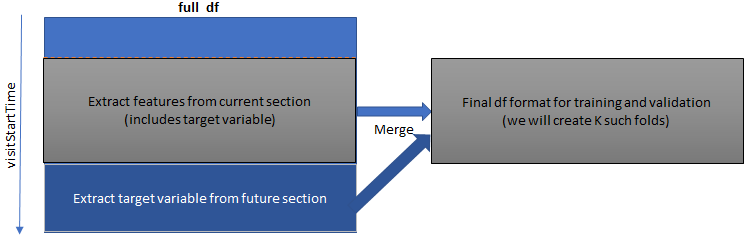

# APPROACH: LOOKAHEAD REGRESSION PREDICTIONS
* Now we can finally experiment with Regression models. Although the distribution of data is likely to give pretty poor results!

* I found an interesting blog-post which deals with [explaination of xgboost from the official author](https://homes.cs.washington.edu/~tqchen/2016/03/10/story-and-lessons-behind-the-evolution-of-xgboost.html).

* Also spent some time understanding [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting).

We can also attempt to fit the lgb, xgb & catboost model on the entire train-dataset, just like a normal problem statement, without considering specific timeframes. During the time of _'submission.csv'_ creation, we'd just need to group all 'fullVisitorId's and aggregate their predictions using sum().

However this approach gives pretty poor results on the Private LB ~ 1.5

Instead we can select the chunk of data from lower timeframe -> extract its features -> merge this chunk with a future timeframe's target-variable ie 'totals.transactionRevenue' -> test accuracy of our regression model.

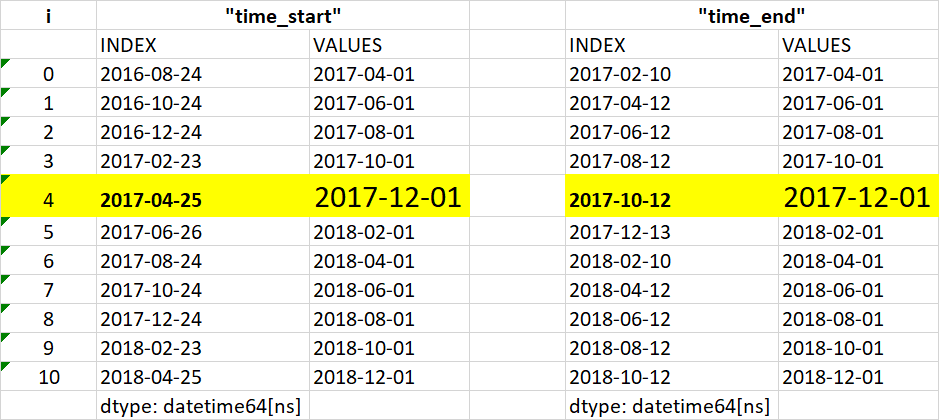

In [ ]:
def preprocess_and_standardize(train_df, test_df):
    full_df=pd.concat([train_df,test_df],axis=0)

    ''' SET DATE FEATURES AS SEPERATE COLUMNS '''
    full_df['date.weekday']=full_df['date'].dt.weekday
    full_df['date.day']=full_df['date'].dt.day
    full_df['date.month']=full_df['date'].dt.month
    full_df['date.year']=full_df['date'].dt.year
    
    ''' DROP COLS WITH NOT MUCH RELEVANCE , AND COLS WITH CONSTANT VAL '''
    print('Columns with cardinality=1 ie Constant value : ',full_df.nunique()[full_df.nunique()==1].index)
    _COLS_TO_DROP=[ 'trafficSource.adContent', 'visitId', 'device.isMobile', 'trafficSource.referralPath', 
                    'totals.totalTransactionRevenue', 'visitNumber', 'visitStartTime',
                    'totals.bounces','totals.newVisits','socialEngagementType','trafficSource.isTrueDirect',]
    for c in _COLS_TO_DROP:
        try:
            del(full_df[c])
        except:
            pass
    print('{} I) DROPPED UNNECESSARY COLUMNS {}'.format('#'*26 , '#'*26))

    
    ''' IDENTIFIED BROWSER NAMES WHICH SEEM LEGIT, AND SET THE REST TO <Others> TO AVOID HIGH CARDINALITY '''
    _VALID_BROWSERS = [ 'Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Android Webview', 'Edge', 'Samsung Internet']
    full_df['device.browser'].loc[~full_df['device.browser'].isin(_VALID_BROWSERS)]='Other'

    ''' IDENTIFIED OS NAMES WHICH SEEM LEGIT, AND SET THE REST TO <Others> TO AVOID HIGH CARDINALITY '''
    _VALID_OPERATING_SYSTEMS = ['Windows', 'Macintosh', 'Android', 'iOS', 'Linux', 'Chrome OS', 'Windows Phone', 'Samsung']
    full_df['device.operatingSystem'].loc[~full_df['device.operatingSystem'].isin(_VALID_OPERATING_SYSTEMS)]='Other'

    ''' STANDARDIZE TRAFFIC SOURCES INFO '''
    full_df['trafficSource.keyword']=full_df['trafficSource.keyword'].fillna('other')
    full_df['trafficSource.keyword']=full_df['trafficSource.keyword'].apply(standardize_traffic_keyword)
    full_df['trafficSource.source']=full_df['trafficSource.source'].apply(standardize_traffic_source)
    full_df['trafficSource.adwordsClickInfo.slot']=full_df['trafficSource.adwordsClickInfo.slot'].fillna('No Traffic-ad Slot')
    
    print('{} II) STANDARDIZED COLUMN VALUES {}'.format('#'*26 , '#'*26))
    
    ''' ENCODE THE FINAL CATEGORICAL COLS INTO LABEL-ENCODINGS OF <n-1> VALUES EACH '''
    _CAT_COLS_FOR_ENCODER = ['channelGrouping', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 
                         'geoNetwork.city','geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.region',
                         'geoNetwork.subContinent','geoNetwork.networkDomain','trafficSource.medium', 'trafficSource.source',
                         'trafficSource.campaign','trafficSource.keyword','trafficSource.adwordsClickInfo.slot']
    
    print('{} III) ENCODING RELEVANT COLUMNS TO LABELS {}'.format('#'*26 , '#'*26))
    for col in _CAT_COLS_FOR_ENCODER:
        print('Converting <',col,'> to labels.')
        if full_df[col].dtype.name=='object':
            lb = LabelEncoder()
            full_df[col]=lb.fit_transform(full_df[col])
    
    return full_df






def return_aggregated_df(input_df, i=0, create_test=False, verbose=True):
    
    if create_test==False:
        ''' EXTRACT FEATURES FROM PREVIOUS TIMEFRAME '''
        feature_df = input_df[(pd.to_datetime(input_df['date']) > time_from.index[i]) & (pd.to_datetime(input_df['date']) <= time_end.index[i])].copy()
    else:
        ''' USE THE INPUT DATASET AS IS '''
        feature_df = input_df
    
    if verbose==True:
        print('{} A) CREATED BASE-FEATURE DATAFRAME {}'.format('#'*26 , '#'*26))
    
    _COLS_TO_MEDIAN_VAL =  ['channelGrouping' , 'device.browser' , 'device.deviceCategory' , 'device.operatingSystem' , 'geoNetwork.city' , 'geoNetwork.country' , 
                            'geoNetwork.metro' , 'geoNetwork.networkDomain' , 'geoNetwork.region' , 'geoNetwork.subContinent', 'geoNetwork.continent' , 
                            'trafficSource.medium' , 'trafficSource.source' , 'trafficSource.campaign' , 'trafficSource.keyword' , 'trafficSource.adwordsClickInfo.slot']
    _COLS_TO_SUM_VAL =     ['totals.hits' , 'totals.sessionQualityDim' , 'totals.transactions', 'totals.pageviews' ]
    _COLS_TO_MEAN_VAL =    ['date.year', 'date.month', 'date.day', 'date.weekday']
    _COLS_TO_STD_DEV_VAL = ['totals.hits' , 'totals.pageviews' , 'totals.sessionQualityDim']
    
    ans=pd.concat([
        feature_df.groupby('fullVisitorId')[_COLS_TO_MEDIAN_VAL].median().add_suffix('_median'),
        feature_df.groupby('fullVisitorId')[_COLS_TO_MEAN_VAL].mean().add_suffix('_mean'),
        feature_df.groupby('fullVisitorId')[_COLS_TO_SUM_VAL].sum().add_suffix('_sum'),
        feature_df.groupby('fullVisitorId')[_COLS_TO_STD_DEV_VAL].std(ddof=0).add_suffix('_stdDev'),
        feature_df.groupby('fullVisitorId')['date'].apply(lambda x: (x.max()-x.min())//10**9).rename('time_diff')#,
        #feature_df.groupby('fullVisitorId')['date'].agg(['first','last']).apply(lambda x: (x.astype(int) - time_from.values[i].astype(int))//10**9).abs().add_suffix('_time')
    ], axis=1).reset_index()
    if verbose==True:
        print('{} B) AGGREGATED THE BASE FEATURES {}'.format('#'*26 , '#'*26))
    
    if create_test==False:
        ''' EXTRACT TARGET VARIABLE FROM FUTURE TIMEFRAME'''
        target_df  = input_df[(input_df['date'] > pd.Timestamp(time_from.values[i])) 
                              & (input_df['date'] <= pd.Timestamp(time_from.values[i+1]))].copy()
        ans=ans.merge(target_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index(), how = 'left', on = 'fullVisitorId')
        if verbose==True:
            print('{} C) MERGED THE FUTURE TIMEFRAME TARGET WITH AGGREGATED FEATURES {}'.format('#'*26 , '#'*26))
        ans['totals.transactionRevenue']=ans['totals.transactionRevenue'].fillna(0).apply(lambda y: np.log(y) if y>0 else y)
    
    return ans

In [ ]:
full_df = preprocess_and_standardize(train,test)

''' WE USE THE BELOW DATE-RANGE VARIABLES FOR CREATING CV-FOLDS BASED ON TIME  '''
overall_period = pd.date_range(start='2016-08-01',end='2018-12-01', freq='2MS')  #Catch the start-date of every alternate month from Aug-1st-2016 to Dec-1st-2018
train_period = overall_period.to_series().shift(periods=-220, freq='d',axis= 0)  #Shift the index of 'overall_period' by -220 days (will be used for features of dataset)
time_from = train_period[train_period.index>np.datetime64('2016-08-01')]         #Select only those values where index > Aug-2016
time_end = overall_period.to_series().shift(periods=-50, freq='d',axis= 0)[4:]   #Shift the index of 'overall_period' by only -50 days (will be used for target variable of dataset)

print('[time_from] <Aug-2016 to May-2018> :\n',time_from)
print('\n[time_end] <Feb-2017 to Oct-2018> :\n',time_end)
print("\nNOTE:\nWe\'ll set aside a validation-dataset of features from 170 days with start-date as {}\'th entry of [time_from]=\'{}\' and end-date as {}\'th entry of [time_end]=\'{}\''.".format(i,time_from.index[i],i,time_end.index[i]))


''' SET ASIDE ONE VALIDATION DATASET '''
i=4
val_df = return_aggregated_df(full_df, i)
validation_y=val_df['totals.transactionRevenue']
validation_x=val_df.copy().drop(['fullVisitorId','totals.transactionRevenue'],inplace=False,axis=1).astype(int)
print('{} V) CREATED VALIDATION-DATASET FOR APPROACH 2 {}'.format('#'*26 , '#'*26))

In [ ]:
submissions_df=pd.DataFrame()

test_df = full_df.iloc[train_shape[0]:, :] #SHAPE = <1708337, 15> with 296530 unique fullVisitorIds
test_x=return_aggregated_df(test_df,i=0,create_test=True )

submissions_df['fullVisitorId']=test_x['fullVisitorId'].copy()
test_x=test_x.drop(['fullVisitorId'],axis=1).astype(int)
print('{} IV) CREATED TEST-DATASET FOR APPROACH 2 {}'.format('#'*26 , '#'*26))

In [ ]:
tmp=pd.DataFrame()
tmp['features']=full_df.corr()['totals.transactionRevenue'].sort_values(ascending=False).index
tmp['feature_correlation']=full_df.corr()['totals.transactionRevenue'].sort_values(ascending=False).values
plt.figure(figsize=(10,12))
plt.title('Feature Correlation with Target Label', fontdict={'fontweight':'bold'})
sns.barplot(x='feature_correlation',y='features',data=tmp, palette='Accent')
plt.show()

In [ ]:
val_df[['fullVisitorId','totals.transactions_sum','totals.transactionRevenue']][val_df['totals.transactionRevenue']>0].head(10)

In [ ]:
''' HYBRID APPROACH '''
try:
    del(test_df)
    del(tmp)
    del(val_df)
except:
    pass
submission_catboost_preds = np.zeros(len(test_x))
submission_xgb_preds = np.zeros(len(test_x))
submission_lgb_preds = np.zeros(len(test_x))

kfold=list(range(time_from.shape[0]-1))
kfold.remove(4)
for fold in kfold:
    fold_df = return_aggregated_df(full_df, fold, verbose=False)
    train_y = fold_df['totals.transactionRevenue']
    train_x = fold_df.copy().drop(['fullVisitorId','totals.transactionRevenue'],inplace=False,axis=1).astype(int)
    print('\n{} {}.1) CREATED TRAIN SET OF <{}> FOR THIS FOLD {}'.format(26*'#', fold, train_x.shape, 26*'#'))
    
    try:
        del(fold_df)
    except:
        pass
    
    print('\n{} {}.2) TRAINING CatBoostRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    catboost = CatBoostRegressor(iterations=1100,learning_rate=0.04, depth=10, bagging_temperature = 0.2, od_wait=20,
                                 eval_metric='RMSE', random_seed=0, od_type='Iter')
    catboost.fit(train_x , train_y, eval_set=[(validation_x, validation_y)],early_stopping_rounds=100, use_best_model=True, verbose=100)
    
    predictions = catboost.predict(validation_x)
    predictions[predictions<0]=0
    print('{}{}.3) CATBOOST REGRESSION LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))
    

    submission_preds_raw=catboost.predict(test_x)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_catboost_preds += submission_preds_raw / len(kfold)


    print('\n{} {}.4) TRAINING XGBRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    xgb = XGBRegressor(n_estimators=1000, max_depth=20, learning_rate=0.07, booster='gbtree', random_state=0, importance_type='total_gain',
                       objective= 'reg:squarederror', gamma=1.45, alpha=0.0, subsample=0.67, colsample_bytree=0.054, colsample_bylevel= 0.50)
    xgb.fit(train_x , train_y ,eval_set=[(validation_x, validation_y)], early_stopping_rounds=100, eval_metric='rmse', verbose=100)
    predictions = xgb.predict(validation_x)
    predictions[predictions<0]=0
    print('{}{}.5) XGB LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))

    submission_preds_raw=xgb.predict(test_x)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_xgb_preds +=  submission_preds_raw / len(kfold)
    
    
    
    print('\n{} {}.6) TRAINING LGBRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    lgb_reg = lgb.LGBMRegressor(n_estimators=1100, objective='regression', max_depth=-1, learning_rate=0.08, min_child_samples=40, boosting='gbdt', 
                                feature_fraction=0.9, bagging_freq=10, bagging_fraction=0.8, bagging_seed=3, metric='rmse', lambda_l1=0, lambda_l2=1, verbosity=100)
    lgb_reg.fit(train_x, train_y, eval_set= [(validation_x, validation_y)], eval_metric='rmse', verbose=100 ,early_stopping_rounds = 100)
    predictions = lgb_reg.predict(validation_x.values, num_iteration=lgb_reg.best_iteration_)
    predictions[predictions<0]=0
    print('{}{}.7) LGB LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y.values, predictions)**.5, '<'*26))
    submission_preds_raw=lgb_reg.predict(test_x.values, num_iteration=lgb_reg.best_iteration_)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_lgb_preds +=  submission_preds_raw / len(kfold)

# STRAIGHTFORWARD APPROACH DOESNT GIVE GREAT PERFORMANCE
Hence commented this out for now.

try:
    del(fulltrain_df)
except:
    pass
submission_catboost_preds = np.zeros(len(test_x))
submission_xgb_preds = np.zeros(len(test_x))
submission_lgb_preds = np.zeros(len(test_x))

kfold=KFold(n_splits=5, shuffle=True, random_state=100)

for fold, (train_indices,validation_indices) in enumerate(kfold.split(fulltrain_x.values,fulltrain_y.values)):
    train_y = fulltrain_y.iloc[train_indices]
    train_x = fulltrain_x.iloc[train_indices].astype(int)
    validation_y = fulltrain_y.iloc[validation_indices]
    validation_x = fulltrain_x.iloc[validation_indices].astype(int)
    print('\n{} {}.1) CREATED TRAIN AND DEV SETS FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    
    
    print('\n{} {}.2) TRAINING CatBoostRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    catboost = CatBoostRegressor(iterations=1000,learning_rate=0.03, depth=10, eval_metric='RMSE', random_seed = 0,
                                 bagging_temperature = 0.2, od_type='Iter', od_wait=20)
    catboost.fit(train_x , train_y, eval_set=[(validation_x, validation_y)],early_stopping_rounds=70, use_best_model=True, verbose=100)
    
    predictions = catboost.predict(validation_x)
    predictions[predictions<0]=0
    print('{}{}.3) CATBOOST REGRESSION LOSS ={}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))
    
    submission_preds_raw=catboost.predict(test_x)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_catboost_preds += submission_preds_raw / kfold.n_splits
    
    
    
    print('\n{} {}.4) TRAINING XGBRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    xgb = XGBRegressor(n_estimators=1000, max_depth=20, learning_rate=0.07, booster='gbtree', random_state=0, importance_type='total_gain',
                       objective= 'reg:squarederror', gamma=1.45, alpha=0.0, subsample=0.67, colsample_bytree=0.054, colsample_bylevel= 0.50)
    xgb.fit(train_x , train_y ,eval_set=[(validation_x, validation_y)], early_stopping_rounds=70, eval_metric='rmse', verbose=100)
    predictions = xgb.predict(validation_x)
    predictions[predictions<0]=0
    print('{}{}.5) XGB LOSS ={}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))

    submission_preds_raw=xgb.predict(test_x)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_xgb_preds +=  submission_preds_raw / kfold.n_splits
    
    

    print('\n{} {}.6) TRAINING LGBRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    trn_data = lgb.Dataset(fulltrain_x.iloc[train_indices], label=fulltrain_y.iloc[train_indices])
    val_data = lgb.Dataset(fulltrain_x.iloc[validation_indices], label=fulltrain_y.iloc[validation_indices])
    clf = lgb.train(params={
                        'objective':'regression', 'max_depth':-1, 'learning_rate':0.05, 'min_child_samples':40, 'boosting':"gbdt", 'feature_fraction':0.8, 
                        'bagging_freq':1, 'bagging_fraction':0.8, 'bagging_seed':3,'metric':'rmse', 'lambda_l1':1, 'lambda_l2':1, 'verbosity':100
                    },train_set=trn_data, num_boost_round=10000, valid_sets = [trn_data, val_data], verbose_eval=500 ,early_stopping_rounds = 500)
    predictions = clf.predict(validation_x.values, num_iteration=clf.best_iteration)
    predictions[predictions<0]=0
    print('{}{}.7) LGB LOSS ={}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y.values, predictions)**.5, '<'*26))
        
    submission_preds_raw=clf.predict(test_x.values, num_iteration=clf.best_iteration)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_lgb_preds +=  submission_preds_raw / kfold.n_splits

In [ ]:
feature_importances=pd.DataFrame()
feature_importances['features']=train_x.columns
feature_importances['feature_importance']=catboost.get_feature_importance()

plt.figure(figsize=(10,12))
sns.barplot(x='feature_importance',y='features',data=feature_importances.sort_values('feature_importance',ascending=False), palette='twilight')
plt.title('Feature Importance as per Catboost-Regressor', fontdict={'fontweight':'bold'})
plt.show()

In [ ]:
feature_importances=pd.DataFrame()
feature_importances['features']=train_x.columns
feature_importances['feature_importance']=xgb.feature_importances_

plt.figure(figsize=(10,12))
plt.title('Feature Importance as per XGBRegressor', fontdict={'fontweight':'bold'}) 
sns.barplot(x='feature_importance',y='features',data=feature_importances.sort_values('feature_importance',ascending=False), palette='twilight_shifted_r')
plt.show()

In [ ]:
feature_importances=pd.DataFrame()
feature_importances['features']=train_x.columns
feature_importances['feature_importance']=lgb_reg.feature_importances_
plt.figure(figsize=(10,12)) 
plt.title('Feature Importance as per LGBRegressor', fontdict={'fontweight':'bold'})
sns.barplot(x='feature_importance',y='features',data=feature_importances.sort_values('feature_importance',ascending=False), palette='twilight_r')
plt.show()

In [ ]:
submissions_df['PredictedLogRevenue'] = submission_lgb_preds*0.4 + submission_catboost_preds*0.5 + submission_xgb_preds*0.1
submissions_df.to_csv('result.csv', index=False)
print("Done")